In [22]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import json

In [23]:
json_file_path = "./output/encoding_d7-204252.json"

with open(json_file_path, 'r') as j:
    contents = json.loads(j.read())

In [24]:
contents

{'Proto': {'10': 'tcp',
  '11': 'udp',
  '1': 'icmp',
  '0': 'arp',
  '9': 'rtp',
  '5': 'ipx/spx',
  '8': 'rtcp',
  '3': 'ipv6',
  '6': 'pim',
  '2': 'igmp',
  '12': 'udt',
  '7': 'rarp',
  '4': 'ipv6-icmp'},
 'Dir': {'4': '  <?>',
  '1': '   ?>',
  '3': '  <->',
  '0': '   ->',
  '5': '  who',
  '2': '  <-'},
 'State': {'106': 'RPA_FPA',
  '108': 'RPA_PA',
  '89': 'PA_A',
  '92': 'PA_PA',
  '105': 'RPA_',
  '102': 'RA_PA',
  '34': 'FRA_PA',
  '4': 'CON',
  '95': 'PA_RPA',
  '19': 'FPA_FA',
  '12': 'FA_FA',
  '74': 'INT',
  '20': 'FPA_FPA',
  '11': 'FA_A',
  '94': 'PA_RA',
  '15': 'FA_R',
  '101': 'RA_FPA',
  '170': 'URP',
  '3': 'A_PA',
  '164': 'URH',
  '52': 'FSPA_FSPA',
  '154': 'S_RA',
  '103': 'RED',
  '91': 'PA_FRPA',
  '13': 'FA_FPA',
  '107': 'RPA_FSRPA',
  '38': 'FRPA_FPA',
  '54': 'FSPA_FSRPA',
  '2': 'A_A',
  '28': 'FRA_',
  '29': 'FRA_A',
  '141': 'SRPA_FSPA',
  '173': '_FSPA',
  '65': 'FSRPA_FSPA',
  '142': 'SRPA_FSRPA',
  '88': 'PA_',
  '14': 'FA_FRA',
  '21': 'FPA_FRA'

In [25]:
ruleset_df = pd.read_csv("./output/ruleset_d7-204252.csv", index_col=0)
flow_df = pd.read_csv("capture20110818-2.binetflow")

In [26]:
flow_df['Label'].unique()
malicious = list(filter(lambda x: "Botnet" in x, flow_df['Label'].unique()))

all_bad_db = flow_df[flow_df["Label"].isin(malicious)]
all_good_db = flow_df[~ flow_df["Label"].isin(malicious)]

# Port analysis
good_sport_df = pd.DataFrame(all_good_db['Sport'])

# Fill Sport for null to 0 and convert to int
good_sport_df = pd.DataFrame(good_sport_df['Sport'].fillna(value="0"))
good_sport_df = pd.DataFrame(good_sport_df['Sport'].apply(lambda x: int(int(x, 16))))


In [27]:
good_sport_df

,Sport
0,4216
1,78113
2,128
3,345368
4,102531
...,...
107246,357237
107247,406864
107248,365697
107249,356370


In [28]:
n_of_ports = 10
plt.rcParams.update({'font.size': 22})
file_time = str("d"
                + str(datetime.now().day)
                + "-"
                + str(datetime.now().hour)
                + str(datetime.now().minute)
                + str(datetime.now().second))

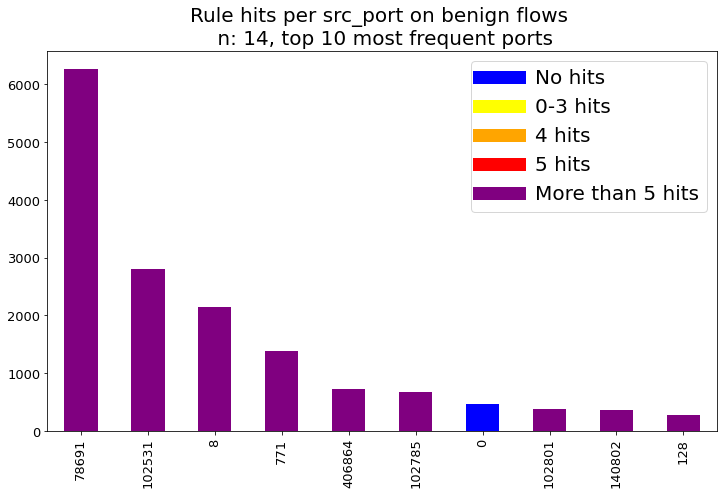

In [29]:
plt.figure(figsize=(12, 7))

freq_good_sport = good_sport_df['Sport'].value_counts()
red_freq_good_sport = freq_good_sport[0:n_of_ports]

coloured_bars = []
nhit_on_freq_good_sport = {}

for _, ruleset in ruleset_df.iterrows():
    #print(ruleset)
    for port in red_freq_good_sport.index:
        if ruleset['Sport_greater'] is None:
            continue
        if not port in nhit_on_freq_good_sport.keys():
            nhit_on_freq_good_sport[port] = 0
        if ruleset['Sport_greater']:
            if port > ruleset['Sport_threshold']:
                nhit_on_freq_good_sport[port] += 1
        if not ruleset['Sport_greater']:
            if port > ruleset['Sport_threshold']:
                nhit_on_freq_good_sport[port] += 1

#TODO In the future, distinguish by number of hits

for k in nhit_on_freq_good_sport.keys():
    if nhit_on_freq_good_sport[k] > 0:
        coloured_bars.append(k)

good_sport_color = [{f not in nhit_on_freq_good_sport.keys(): 'blue',
                     nhit_on_freq_good_sport[f] == 4: 'orange',
                     nhit_on_freq_good_sport[f] == 5: 'red',
                     nhit_on_freq_good_sport[f] == 0: 'blue',
                     nhit_on_freq_good_sport[f] > 0: 'yellow',
                     nhit_on_freq_good_sport[f] > 5: 'purple',

                     }[True] for f in red_freq_good_sport.index]

good_sport_bar_plot = red_freq_good_sport.plot.bar(color=good_sport_color)

plt.plot(0, 0, 'blue', label='No hits', lw=13)
plt.plot(0, 0, 'yellow', label='0-3 hits', lw=13)
plt.plot(0, 0, 'orange', label='4 hits', lw=13)
plt.plot(0, 0, 'red', label='5 hits', lw=13)
plt.plot(0, 0, 'purple', label='More than 5 hits', lw=13)
plt.legend(fontsize=18)

label_to_remove = 'Sport'
h, l = good_sport_bar_plot.get_legend_handles_labels()

idx_keep = [k[0] for k in enumerate(l) if l[k[0]] != label_to_remove]

handles = []
labels = []

for i in idx_keep:
    handles.append(h[i])
    labels.append(l[i])
good_sport_bar_plot.legend(handles, labels, prop={'size': 20})
plt.title("Rule hits per src_port on benign flows \n n: " + str(len(ruleset_df)) + ", top " + str(n_of_ports) + " most frequent ports",
          fontsize=20)
good_sport_bar_plot.tick_params(axis='both', which='major', labelsize=13)
plt.savefig("./output/figures/fig_good_sport_" + file_time + ".png", transparent=True)
plt.show()

Below here is the same analysis as above, but for Dport

In [30]:
# Port analysis
good_dport_df = pd.DataFrame(all_good_db['Dport'])

# Fill Sport for null to 0 and convert to int
good_dport_df = pd.DataFrame(good_dport_df['Dport'].fillna(value="0"))
good_dport_df = pd.DataFrame(good_dport_df['Dport'].apply(lambda x: int(int(x, 16))))


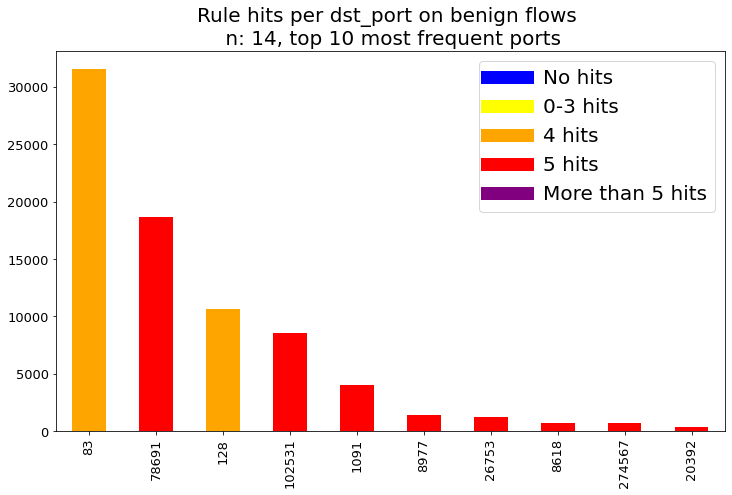

In [31]:
plt.figure(figsize=(12, 7))

freq_good_dport = good_dport_df['Dport'].value_counts()
red_freq_good_dport = freq_good_dport[0:n_of_ports]

coloured_bars_good_dport = []
nhit_on_freq_good_dport = {}

for _, ruleset in ruleset_df.iterrows():
    #print(ruleset)
    for port in red_freq_good_dport.index:
        if ruleset['Dport_greater'] is None:
            continue
        if not port in nhit_on_freq_good_dport.keys():
            nhit_on_freq_good_dport[port] = 0
        if ruleset['Dport_greater']:
            if port > ruleset['Dport_threshold']:
                nhit_on_freq_good_dport[port] += 1
        if not ruleset['Dport_greater']:
            if port > ruleset['Dport_threshold']:
                nhit_on_freq_good_dport[port] += 1

for k in nhit_on_freq_good_dport.keys():
    if nhit_on_freq_good_dport[k] > 0:
        coloured_bars_good_dport.append(k)

good_dport_color = [{f not in nhit_on_freq_good_dport.keys(): 'blue',
                     nhit_on_freq_good_dport[f] == 0: 'blue',
                     nhit_on_freq_good_dport[f] > 0: 'yellow',
                     nhit_on_freq_good_dport[f] == 4: 'orange',
                     nhit_on_freq_good_dport[f] == 5: 'red',
                     }[True] for f in red_freq_good_dport.index]

good_dport_bar_plot = red_freq_good_dport.plot.bar(color=good_dport_color)

plt.plot(0, 0, 'blue', label='No hits', lw=13)
plt.plot(0, 0, 'yellow', label='0-3 hits', lw=13)
plt.plot(0, 0, 'orange', label='4 hits', lw=13)
plt.plot(0, 0, 'red', label='5 hits', lw=13)
plt.plot(0, 0, 'purple', label='More than 5 hits', lw=13)
plt.legend(fontsize=18)

label_to_remove = 'Dport'
h, l = good_dport_bar_plot.get_legend_handles_labels()

idx_keep = [k[0] for k in enumerate(l) if l[k[0]] != label_to_remove]

handles = []
labels = []

for i in idx_keep:
    handles.append(h[i])
    labels.append(l[i])
good_dport_bar_plot.legend(handles, labels, prop={'size': 20})
good_dport_bar_plot.tick_params(axis='both', which='major', labelsize=13)
plt.title("Rule hits per dst_port on benign flows \n n: " + str(len(ruleset_df)) + ", top " + str(n_of_ports) + " most frequent ports",
          fontsize=20)

plt.savefig("./output/figures/fig_good_dport_" + file_time + ".png", transparent=True)
plt.show()

In [32]:
nhit_on_freq_good_dport

{83: 4,
 78691: 5,
 128: 4,
 102531: 5,
 1091: 5,
 8977: 5,
 26753: 5,
 8618: 5,
 274567: 5,
 20392: 5}

In [33]:
# Port analysis
bad_dport_df = pd.DataFrame(all_bad_db['Dport'])

# Fill Sport for null to 0 and convert to int
bad_dport_df = pd.DataFrame(bad_dport_df['Dport'].fillna(value="0"))
bad_dport_df = pd.DataFrame(bad_dport_df['Dport'].apply(lambda x: int(int(str(x), 16))))


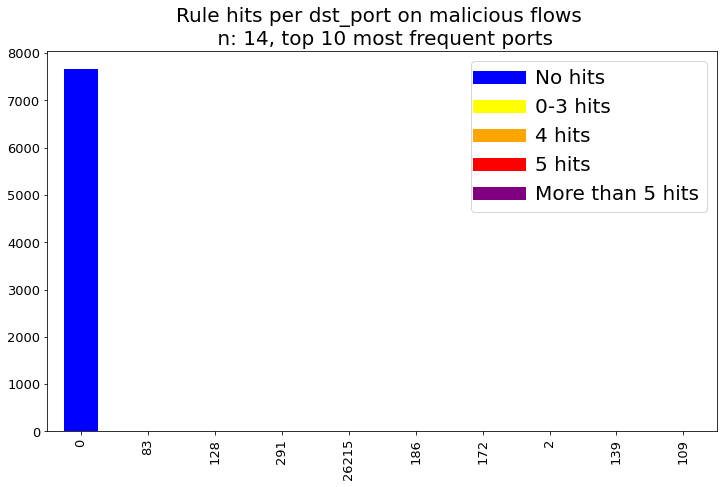

In [34]:
plt.figure(figsize=(12, 7))

freq_bad_dport = bad_dport_df['Dport'].value_counts()
red_freq_bad_dport = freq_bad_dport[0:n_of_ports]

coloured_bars_bad_dport = []
nhit_on_freq_bad_dport = {}

for _, ruleset in ruleset_df.iterrows():
    #print(ruleset)
    for port in red_freq_bad_dport.index:
        if ruleset['Dport_greater'] is None:
            continue
        if not port in nhit_on_freq_bad_dport.keys():
            nhit_on_freq_bad_dport[port] = 0
        if ruleset['Dport_greater']:
            if port > ruleset['Dport_threshold']:
                nhit_on_freq_bad_dport[port] += 1
        if not ruleset['Dport_greater']:
            if port > ruleset['Dport_threshold']:
                nhit_on_freq_bad_dport[port] += 1

for k in nhit_on_freq_bad_dport.keys():
    if nhit_on_freq_bad_dport[k] > 0:
        coloured_bars_bad_dport.append(k)

bad_dport_color = [{f not in nhit_on_freq_bad_dport.keys(): 'blue',
                    nhit_on_freq_bad_dport[f] == 0: 'blue',
                    nhit_on_freq_bad_dport[f] > 0: 'yellow',
                    nhit_on_freq_bad_dport[f] == 4: 'orange',
                    nhit_on_freq_bad_dport[f] == 5: 'red',
                    nhit_on_freq_bad_dport[f] > 5: 'purple',
                    }[True] for f in red_freq_bad_dport.index]

bad_dport_bar_plot = red_freq_bad_dport.plot.bar(color=bad_dport_color)

plt.plot(0, 0, 'blue', label='No hits', lw=13)
plt.plot(0, 0, 'yellow', label='0-3 hits', lw=13)
plt.plot(0, 0, 'orange', label='4 hits', lw=13)
plt.plot(0, 0, 'red', label='5 hits', lw=13)
plt.plot(0, 0, 'purple', label='More than 5 hits', lw=13)
plt.legend(fontsize=18)

label_to_remove = 'Dport'
h, l = bad_dport_bar_plot.get_legend_handles_labels()

idx_keep = [k[0] for k in enumerate(l) if l[k[0]] != label_to_remove]

handles = []
labels = []

for i in idx_keep:
    handles.append(h[i])
    labels.append(l[i])
bad_dport_bar_plot.legend(handles, labels, prop={'size': 20})

bad_dport_bar_plot.tick_params(axis='both', which='major', labelsize=13)
plt.title("Rule hits per dst_port on malicious flows \n n: " + str(len(ruleset_df)) + ", top " + str(n_of_ports) + " most frequent ports",
          fontsize=20)
plt.savefig("./output/figures/fig_bad_dport_" + file_time + ".png", transparent=True)
plt.show()

In [35]:
freq_bad_dport

0        7663
83         14
128         5
291         3
26215       3
         ... 
202         2
225         2
93          2
196         2
65          2
Name: Dport, Length: 243, dtype: int64

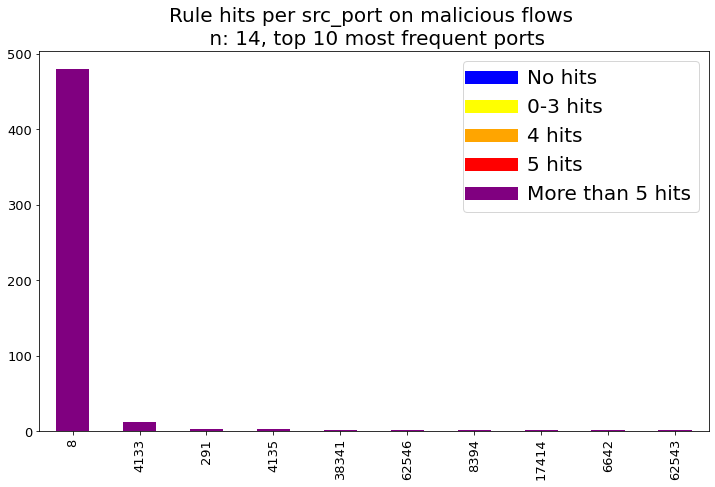

In [36]:
# Port analysis
bad_sport_df = pd.DataFrame(all_bad_db['Sport'])

# Fill Sport for null to 0 and convert to int
bad_sport_df = pd.DataFrame(bad_sport_df['Sport'].fillna(value="0"))
bad_sport_df = pd.DataFrame(bad_sport_df['Sport'].apply(lambda x: int(int(str(x), 16))))

plt.figure(figsize=(12, 7))

freq_bad_sport = bad_sport_df['Sport'].value_counts()
red_freq_bad_sport = freq_bad_sport[0:n_of_ports]

coloured_bars_bad_sport = []
nhit_on_freq_bad_sport = {}

for _, ruleset in ruleset_df.iterrows():
    #print(ruleset)
    for port in red_freq_bad_sport.index:
        if ruleset['Sport_greater'] is None:
            continue
        if not port in nhit_on_freq_bad_sport.keys():
            nhit_on_freq_bad_sport[port] = 0
        if ruleset['Sport_greater']:
            if port > ruleset['Sport_threshold']:
                nhit_on_freq_bad_sport[port] += 1
        if not ruleset['Sport_greater']:
            if port > ruleset['Sport_threshold']:
                nhit_on_freq_bad_sport[port] += 1

for k in nhit_on_freq_bad_sport.keys():
    if nhit_on_freq_bad_sport[k] > 0:
        coloured_bars_bad_sport.append(k)

bad_sport_color = [{f not in nhit_on_freq_bad_sport.keys(): 'blue',
                    nhit_on_freq_bad_sport[f] == 4: 'orange',
                    nhit_on_freq_bad_sport[f] == 5: 'red',
                    nhit_on_freq_bad_sport[f] == 0: 'blue',
                    nhit_on_freq_bad_sport[f] > 0: 'yellow',
                    nhit_on_freq_bad_sport[f] > 5: 'purple',

                    }[True] for f in red_freq_bad_sport.index]

bad_sport_bar_plot = red_freq_bad_sport.plot.bar(color=bad_sport_color)

plt.plot(0, 0, 'blue', label='No hits', lw=13)
plt.plot(0, 0, 'yellow', label='0-3 hits', lw=13)
plt.plot(0, 0, 'orange', label='4 hits', lw=13)
plt.plot(0, 0, 'red', label='5 hits', lw=13)
plt.plot(0, 0, 'purple', label='More than 5 hits', lw=13)
plt.legend(fontsize=18)

label_to_remove = 'Sport'
h, l = bad_sport_bar_plot.get_legend_handles_labels()

idx_keep = [k[0] for k in enumerate(l) if l[k[0]] != label_to_remove]

handles = []
labels = []

for i in idx_keep:
    handles.append(h[i])
    labels.append(l[i])
bad_sport_bar_plot.legend(handles, labels, prop={'size': 20})

bad_sport_bar_plot.tick_params(axis='both', which='major', labelsize=13)
plt.title("Rule hits per src_port on malicious flows \n n: " + str(len(ruleset_df)) + ", top " + str(n_of_ports) + " most frequent ports",
          fontsize=20)
plt.savefig("./output/figures/fig_bad_sport_" + file_time + ".png", transparent=True)
plt.show()

In [37]:
nhit_on_freq_bad_sport

{8: 10,
 4133: 10,
 291: 10,
 4135: 10,
 38341: 10,
 62546: 10,
 8394: 10,
 17414: 10,
 6642: 10,
 62543: 10}